In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib.pyplot import plot as plt
import collections

import random

import optuna

from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

import statsmodels.api as sm
from patsy import dmatrices

import matplotlib.pyplot as plt

import iml_od_preprocessing
import iml_od_modelling

In [2]:
df = pd.read_csv('./Data/processed_CAR_data.csv')

df = df.drop(['Unnamed: 0', 'ProductName', 'FullTitle', 
              'ProtocolStatus', 'PlannedPrimaryStudy_CompletionDate', 
              'ActualPrimaryStudy_CompletionDate', 'SynopsisActualDate',
              'Protocol_ActualDate', 'FirstSiteActivated_ActualDate', 
              'FSS_ActualDate', 'FSI_ActualDate', 'FSFV_ActualDate', 
              'LSI_ActualDate', 'LSI_AvgTx_ActualDate', 
              'LSO_2_ActualDate', 'LSO_3_ActualDate', 'LSO_4_ActualDate', 
              'LSO_Final_ActualDate', 'DBL_2_ActualDate', 
              'DBL_3_ActualDate', 'DBL_4_ActualDate', 'DBL_Final_ActualDate'], axis = 1)

df = df.drop(['ActualScreened', 'ActualRescreened', 
              'ActualScreenFailure', 'LegacyCompany'], axis = 1)

df = df.drop(['Protocol_to_FirstSiteActivated', 
              'FirstSiteActivated_to_FSS', 'FSI_to_FSFV', 
              'LSI_to_LSIAvgTxL', 'FSFV_to_LSI'], axis = 1)

df = df[df.CloseOut>=0]

# df = df.drop(['LSO','DBL'], axis = 1)

df_matching = pd.read_csv('./Data/trial_ids_car_data.csv')

df_errors = pd.read_excel('./Data/DM_RT_DATA_INGEST_AUTOMATN_LOGS_PROCESSING.xlsx')

df_errors = df_errors[['STUDY_CODE', 'STUDY_ERROR_STATUS', 
                       'ERROR_STATUS', 'MISSING_DOMAIN', 
                       'DASHBOARD_IMPACT']]

df_errors = df_errors[['STUDY_CODE','MISSING_DOMAIN']].drop_duplicates()

df_errors = iml_od_preprocessing.one_hot_encoding_one_column(df_errors, 'MISSING_DOMAIN')

df_errors = df_errors.groupby('STUDY_CODE').sum().reset_index()



df_trial_ids_errors = df_matching.merge(df_errors)

df_trial_ids_errors = df_trial_ids_errors.rename(columns = {"MATCHED_TRIAL_ID": "ProtocolNum"})

df_trials = df[['ProtocolNum']]

df_trial_ids_errors = df_trials.merge(df_trial_ids_errors, how = 'left')

df_trial_ids_errors = df_trial_ids_errors.fillna(0.0)

df_trial_ids_errors = df_trial_ids_errors.drop(['STUDY_CODE'], axis = 1)

df = df.merge(df_trial_ids_errors, how = 'left')

df_unlock_dates = pd.read_csv('./Data/max_dates_unlocks.csv')

df_unlock_dates = df_unlock_dates.groupby(['ProtocolNum']).agg({
    'Lock_duration':'sum','Unlocks_max_date':'max'}).reset_index()

###

df = df.merge(df_unlock_dates, how = 'left')

df['Unlocks_max_date'] = df['Unlocks_max_date'].fillna('1900-01-01')

df["DBL_ActualDate_new"] = df[["DBL_ActualDate", "Unlocks_max_date"]].max(axis=1)

df["DBL_ActualDate"] = df['DBL_ActualDate_new']

df = df.drop(['DBL_ActualDate_new'], axis = 1)

df['LSO_ActualDate'] = pd.to_datetime(df['LSO_ActualDate'])

df['DBL_ActualDate'] = pd.to_datetime(df['DBL_ActualDate'])

df['CloseOut_new'] = (df['DBL_ActualDate'] - df['LSO_ActualDate']).dt.days

df = df.drop(['Unlocks_max_date'], axis = 1)

df['Lock_duration'] = df['Lock_duration'].fillna(0.0)

###

###PREVIOUS CLOSE OUT

df = df.drop(['CloseOut'], axis = 1)

###

df_expected_lso_dbl = pd.read_csv('./Data/expected_lso_dbl.csv')

df_car_msps_trial_id_matching = pd.read_csv('./Data/expected_lso_dbl_trial_id_matching.csv')

df = df.merge(df_car_msps_trial_id_matching, how = 'left')

df = df.merge(df_expected_lso_dbl, how='left')

df = df.drop(['Trial_ID_CAR','InterACT_Trial_ID', 'Expected_LSO'], axis = 1)

df['Ontime'] = df.DBL_ActualDate<df.Expected_DBL

df['Ontime'] = df['Ontime']*1

df = df.drop(['Expected_DBL'], axis = 1)

### Unlocks feature

unlocks = {}
unlocks['TAK-954-1007'] = 3
unlocks['Pevonedistat-1014'] = 3
unlocks['C34005'] = 3
unlocks['MLN0002-2003'] = 1
unlocks['AP26113-13-301'] = 1
unlocks['Pevonedistat-1012'] = 1
unlocks['DEN-315'] = 1
unlocks['DEN-314'] = 1
unlocks['Pevonedistat-2001'] = 1
unlocks['AP26113-11-101'] = 1
unlocks['TAK-438_305'] = 1
unlocks['MLN0002SC-3031'] = 1
unlocks['DEN-204'] = 1
unlocks['Pevonedistat-1015'] = 1
unlocks['TAK-041-2001'] = 1
unlocks['C34007'] = 1
unlocks['TAK-418-0004'] = 1
unlocks['TAK-925-1009'] = 2
unlocks['TAK-925-1013'] = 1
unlocks['TAK-925-2001'] = 1
unlocks['Vedolizumab-1019'] = 2
unlocks['TAK-954-2003'] = 1
unlocks['TAK-994-1001'] = 1
unlocks['TIMP-GLIA-5001'] = 2
unlocks['SHP634-402'] = 1
unlocks['DEN-307'] = 1
unlocks['Brigatinib-2002'] = 3
unlocks['TAK-951-1001'] = 1
unlocks['TAK-994-1503'] = 1
unlocks['TAK-831-2002'] = 1
unlocks['TAK-935-2004'] = 1

unlocks_column = []

for prot in df.ProtocolNum.to_list():
    
    try:
        cur_unlocks = unlocks[prot]
    except:
        cur_unlocks = 0
    
    unlocks_column.append(cur_unlocks)
    
df['Unlocks'] = unlocks_column

### COVID

df['COVID'] = df['DBL_ActualDate']>'2020-03-15'

df['COVID'] = df['COVID']*1.0

# df = df[df.CloseOut_new>=0]

df

,ProtocolNum,ProtocolPhase,TA,PlannedEnrollment,ActualEnrollment,ActualRandomizedDosed,ActualEarlyTerminated,PercEnrollmentCompleted,PlannedSites,ActiveSites,...,MH,PR,SS,VS,Lock_duration,CloseOut_new,Expected_CloseOut,Ontime,Unlocks,COVID
0,TAK-071-1002,I,NS,46,18,0,12,39.13%,1,1,...,0.0,0.0,0.0,0.0,0.0,289,289.0,0,0,0.0
1,C16014 Korea Continuation,III,Oncology,40,41,0,8,102.50%,11,0,...,0.0,0.0,0.0,0.0,0.0,51,31.0,1,0,0.0
2,C34007,I,Oncology,22,17,11,0,77.27%,5,0,...,0.0,0.0,1.0,0.0,8.0,100,28.0,0,1,1.0
3,TAK-438_115,I,GI,30,30,0,0,100.00%,1,0,...,0.0,0.0,0.0,0.0,0.0,6,6.0,0,0,0.0
4,TAK-438_302,III,GI,830,236,1,0,28.43%,68,0,...,0.0,0.0,0.0,0.0,0.0,112,50.0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,NOR-202,II,NonCore,840,840,840,0,100.00%,12,0,...,0.0,0.0,0.0,0.0,0.0,71,71.0,0,0,0.0
308,NOR-204,II,NonCore,325,320,0,11,98.46%,10,0,...,0.0,0.0,0.0,0.0,0.0,129,129.0,0,0,0.0
309,NOR-210,II,NonCore,50,50,0,2,100.00%,1,0,...,0.0,0.0,0.0,0.0,0.0,48,NaN,0,0,0.0
310,NOR-211,II,NonCore,"4,176","4,758",0,0,113.94%,1,0,...,0.0,0.0,0.0,0.0,0.0,53,53.0,0,0,0.0


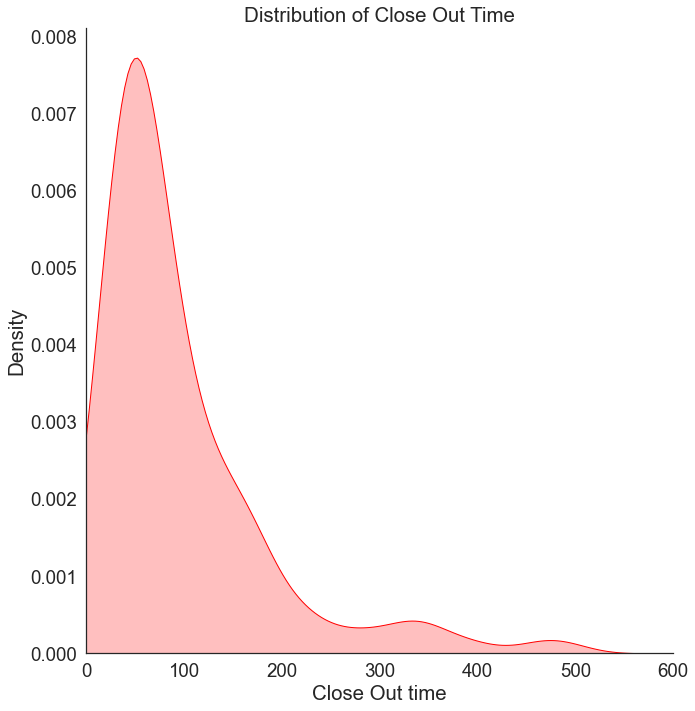

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

df = df[df.CloseOut_new<500]

sns.set(font_scale=1.7)

sns.set_style("white")

ax = sns.displot(df.CloseOut_new, kind="kde", fill=True, color = 'red', height = 10)

ax.set(xlabel='Close Out time', ylabel='Density', title = 'Distribution of Close Out Time', xlim=[0,600])


In [4]:
# df = df[df['DBL_ActualDate'].astype(str).str.contains('2019|2020|2021')]

# df

In [5]:
df.dtypes

ProtocolNum                         object
ProtocolPhase                       object
TA                                  object
PlannedEnrollment                   object
ActualEnrollment                    object
ActualRandomizedDosed                int64
ActualEarlyTerminated                int64
PercEnrollmentCompleted             object
PlannedSites                         int64
ActiveSites                          int64
CRO                                 object
LSO_ActualDate              datetime64[ns]
DBL_ActualDate              datetime64[ns]
numValsLSO                           int64
numValsDBL                           int64
PrimaryStudy_to_Synopsis           float64
Synopsis_to_Protocol               float64
FSS_to_FSI                         float64
LSI_to_LSO                         float64
AE                                 float64
CM                                 float64
DS                                 float64
DV                                 float64
EG         

In [6]:
df.columns

Index(['ProtocolNum', 'ProtocolPhase', 'TA', 'PlannedEnrollment',
       'ActualEnrollment', 'ActualRandomizedDosed', 'ActualEarlyTerminated',
       'PercEnrollmentCompleted', 'PlannedSites', 'ActiveSites', 'CRO',
       'LSO_ActualDate', 'DBL_ActualDate', 'numValsLSO', 'numValsDBL',
       'PrimaryStudy_to_Synopsis', 'Synopsis_to_Protocol', 'FSS_to_FSI',
       'LSI_to_LSO', 'AE', 'CM', 'DS', 'DV', 'EG', 'EX', 'FA', 'LB', 'MH',
       'PR', 'SS', 'VS', 'Lock_duration', 'CloseOut_new', 'Expected_CloseOut',
       'Ontime', 'Unlocks', 'COVID'],
      dtype='object')

In [7]:
df = iml_od_preprocessing.one_hot_encoding_one_column(df, 'ProtocolPhase')

df = iml_od_preprocessing.one_hot_encoding_one_column(df, 'TA')

df['PlannedEnrollment'] = df['PlannedEnrollment'].str.replace(',','.')
df['PlannedEnrollment'] = pd.to_numeric(df['PlannedEnrollment'])

df['ActualEnrollment'] = df['ActualEnrollment'].str.replace(',','.')
df['ActualEnrollment'] = pd.to_numeric(df['ActualEnrollment'])

df['PercActualCompetedTrial'] = (df['ActualEnrollment'] - df['ActualEarlyTerminated'])*100/df['ActualEnrollment']

df['PercEnrollmentCompleted'] = df['PercEnrollmentCompleted'].map(lambda x: str(x)[:-1])
df['PercEnrollmentCompleted'] = pd.to_numeric(df['PercEnrollmentCompleted'])

df = iml_od_preprocessing.CRO_preprocessing(df)
# df = iml_od_preprocessing.one_hot_encoding_one_column(df, 'CRO')



In [8]:
df = df.drop(['ProtocolNum'], axis = 1)

In [9]:
target = 'CloseOut_new'

df_analysis = df

df_analysis = df[df[target]<200][df[target]>=25]

df_analysis = df_analysis[df_analysis[target]>1]

df_restricted = df_analysis

# df_train = df_restricted[~df_restricted['DBL_ActualDate'].str.contains('2019|2020|2021')]
# df_test = df_restricted[df_restricted['DBL_ActualDate'].str.contains('2019')]

split_date = '2020-06-15'

# split_date = '2020-10-01'

df_train = df_restricted[df_restricted['DBL_ActualDate']<split_date]
df_test = df_restricted[df_restricted['DBL_ActualDate']>=split_date]

y_train = df_train[[target]]
y_test = df_test[[target]]
x_train = df_train.drop([target,'DBL_ActualDate','LSO_ActualDate'], axis = 1)
x_test = df_test.drop([target,'DBL_ActualDate','LSO_ActualDate'], axis = 1)

# y_train = np.log(y_train+1e-8)
# y_test = np.log(y_test+1e-8)

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size = 0.25, random_state = 420)


# x_trainvalid = pd.concat([x_train, x_valid])
# y_trainvalid = pd.concat([y_train, y_valid])

x_trainvalid = x_train
y_trainvalid = y_train

ordinal_features = x_train.columns
ordinal_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
        [('ord', ordinal_transformer, ordinal_features)]
)

x_train_processed = preprocessor.fit_transform(x_train)
# x_valid_processed = preprocessor.transform(x_valid)
x_test_processed = preprocessor.transform(x_test)

# x_trainvalid_processed = np.concatenate((x_train_processed,x_valid_processed), axis = 0)

x_trainvalid_processed = x_train_processed




<ipython-input-9-5f28c94c4ab2>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_analysis = df[df[target]<200][df[target]>=25]


In [10]:
df_train.shape

(207, 49)

In [11]:
df_test.shape

(47, 49)

In [12]:
random.seed(3)

n_trials = 100

lm_results, lm_y_test_pred = iml_od_modelling.linear_model(x_trainvalid = x_trainvalid_processed, 
                          x_test = x_test_processed, 
                          y_trainvalid = y_trainvalid, 
                          y_test = y_test)

df_linear_model = pd.DataFrame(lm_results[0], index=[0])

lasso_results, lasso_y_test_pred = iml_od_modelling.linear_lasso(x_tr = x_train_processed, 
#                                              x_val = x_valid_processed, 
                                             x_te = x_test_processed, 
                                             x_trval = x_trainvalid_processed, 
                                             y_tr = y_train, 
#                                              y_val = y_valid, 
                                             y_te = y_test, 
                                             y_trval= y_trainvalid, 
                                             n_trials = n_trials, 
                                              max_alpha = 100)

df_lasso = pd.DataFrame(lasso_results[0], index = [1])

ridge_results, ridge_y_test_pred = iml_od_modelling.linear_ridge(x_tr = x_train_processed, 
#                                              x_val = x_valid_processed, 
                                             x_te = x_test_processed, 
                                             x_trval = x_trainvalid_processed, 
                                             y_tr = y_train, 
#                                              y_val = y_valid, 
                                             y_te = y_test, 
                                             y_trval = y_trainvalid, 
                                             n_trials = n_trials, 
                                              max_alpha = 100)

df_ridge = pd.DataFrame(ridge_results[0], index = [2])

decision_tree_results, dectree_y_test_pred = iml_od_modelling.decision_tree(x_tr = x_train_processed, 
#                                                      x_val = x_valid_processed, 
                                                     x_te = x_test_processed, 
                                                     x_trval = x_trainvalid_processed, 
                                                     y_tr = y_train, 
#                                                      y_val = y_valid, 
                                                     y_te = y_test, 
                                                     y_trval = y_trainvalid, 
                                                     n_trials = n_trials)

df_decision_tree = pd.DataFrame(decision_tree_results[0], index = [3])

lightgbm_results, lgb_y_test_pred = iml_od_modelling.lightgbm_model(x_tr = x_train_processed, 
#                                                      x_val = x_valid_processed, 
                                                     x_te = x_test_processed, 
                                                     x_trval = x_trainvalid_processed, 
                                                     y_tr = y_train, 
#                                                      y_val = y_valid, 
                                                     y_te = y_test, 
                                                     y_trval = y_trainvalid, 
                                                     n_trials = n_trials)

df_lightgbm = pd.DataFrame(lightgbm_results[0], index = [4])

poisson_regression_results, poisson_y_test_pred = iml_od_modelling.poisson_regression(x_tr = x_train_processed, 
#                                                      x_val = x_valid_processed, 
                                                     x_te = x_test_processed, 
                                                     x_trval = x_trainvalid_processed, 
                                                     y_tr = y_train, 
#                                                      y_val = y_valid, 
                                                     y_te = y_test, 
                                                     y_trval = y_trainvalid, 
                                                     n_trials = n_trials, 
                                                     max_alpha = 100)

df_poisson_regression = pd.DataFrame(poisson_regression_results[0], index = [4])



results_concat = pd.concat([df_linear_model, 
                            df_lasso, 
                            df_ridge, 
                            df_decision_tree, 
                            df_lightgbm,
                            df_poisson_regression
                           ])

print(results_concat)



[I 2021-08-19 18:00:45,483] A new study created in memory with name: no-name-2c1d3c50-27a8-461c-8ae8-fbd6aa34fc1c
[I 2021-08-19 18:00:45,553] Trial 0 finished with value: -1905.0548246740982 and parameters: {'lasso_alpha': 41.702200476087185}. Best is trial 0 with value: -1905.0548246740982.
[I 2021-08-19 18:00:45,607] Trial 1 finished with value: -1772.107374916263 and parameters: {'lasso_alpha': 72.03244934701256}. Best is trial 1 with value: -1772.107374916263.
[I 2021-08-19 18:00:45,671] Trial 2 finished with value: -3306.2167766787243 and parameters: {'lasso_alpha': 0.011437491733344915}. Best is trial 1 with value: -1772.107374916263.


Time for preparing linear model result:  0.0  minutes


[I 2021-08-19 18:00:45,715] Trial 3 finished with value: -1934.1139977468058 and parameters: {'lasso_alpha': 30.233257270160653}. Best is trial 1 with value: -1772.107374916263.
[I 2021-08-19 18:00:45,761] Trial 4 finished with value: -2031.4944723510537 and parameters: {'lasso_alpha': 14.675589090243747}. Best is trial 1 with value: -1772.107374916263.
[I 2021-08-19 18:00:45,811] Trial 5 finished with value: -2085.1379571874827 and parameters: {'lasso_alpha': 9.233859485956396}. Best is trial 1 with value: -1772.107374916263.
[I 2021-08-19 18:00:45,884] Trial 6 finished with value: -1999.063910436004 and parameters: {'lasso_alpha': 18.62602114590449}. Best is trial 1 with value: -1772.107374916263.
[I 2021-08-19 18:00:45,976] Trial 7 finished with value: -1921.7090100623846 and parameters: {'lasso_alpha': 34.55607271084917}. Best is trial 1 with value: -1772.107374916263.
[I 2021-08-19 18:00:46,072] Trial 8 finished with value: -1912.8191662847296 and parameters: {'lasso_alpha': 39.67

[I 2021-08-19 18:00:49,050] Trial 46 finished with value: -1750.617440992641 and parameters: {'lasso_alpha': 90.8595503102236}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:49,094] Trial 47 finished with value: -1937.2332890590296 and parameters: {'lasso_alpha': 29.36141484443181}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:49,135] Trial 48 finished with value: -1939.4378351324483 and parameters: {'lasso_alpha': 28.777533865757125}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:49,191] Trial 49 finished with value: -2046.893537631346 and parameters: {'lasso_alpha': 13.002857220527483}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:49,257] Trial 50 finished with value: -2172.7455009927194 and parameters: {'lasso_alpha': 1.9366957968360379}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:49,309] Trial 51 finished with value: -1779.1187477462875 and parameters: {'lass

[I 2021-08-19 18:00:51,139] Trial 89 finished with value: -1791.365962285409 and parameters: {'lasso_alpha': 62.16957202469523}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:51,181] Trial 90 finished with value: -2062.4065230812434 and parameters: {'lasso_alpha': 11.47459730419006}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:51,231] Trial 91 finished with value: -1747.720356701787 and parameters: {'lasso_alpha': 94.94892587121223}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:51,277] Trial 92 finished with value: -1875.0868228167528 and parameters: {'lasso_alpha': 44.991213353494935}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:51,328] Trial 93 finished with value: -1802.9238952010217 and parameters: {'lasso_alpha': 57.83896144292928}. Best is trial 40 with value: -1744.7180213107358.
[I 2021-08-19 18:00:51,376] Trial 94 finished with value: -1911.8379238445486 and parameters: {'lasso

Time for preparing Lasso result:  0.1  minutes


[I 2021-08-19 18:00:51,893] Trial 3 finished with value: -2114.8270558473537 and parameters: {'ridge_alpha': 30.233257270160653}. Best is trial 0 with value: -2109.0920493598346.
[I 2021-08-19 18:00:51,940] Trial 4 finished with value: -2157.7259220180595 and parameters: {'ridge_alpha': 14.675589090243747}. Best is trial 0 with value: -2109.0920493598346.
[I 2021-08-19 18:00:51,986] Trial 5 finished with value: -2205.8979541703325 and parameters: {'ridge_alpha': 9.233859485956396}. Best is trial 0 with value: -2109.0920493598346.
[I 2021-08-19 18:00:52,034] Trial 6 finished with value: -2139.0277656132535 and parameters: {'ridge_alpha': 18.62602114590449}. Best is trial 0 with value: -2109.0920493598346.
[I 2021-08-19 18:00:52,079] Trial 7 finished with value: -2111.4692992450164 and parameters: {'ridge_alpha': 34.55607271084917}. Best is trial 0 with value: -2109.0920493598346.
[I 2021-08-19 18:00:52,125] Trial 8 finished with value: -2109.462340061528 and parameters: {'ridge_alpha': 

[I 2021-08-19 18:00:53,695] Trial 46 finished with value: -2123.2217636046194 and parameters: {'ridge_alpha': 90.8595503102236}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:53,730] Trial 47 finished with value: -2115.7523412173305 and parameters: {'ridge_alpha': 29.36141484443181}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:53,763] Trial 48 finished with value: -2116.427379279077 and parameters: {'ridge_alpha': 28.777533865757125}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:53,796] Trial 49 finished with value: -2168.8430059184398 and parameters: {'ridge_alpha': 13.002857220527483}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:53,843] Trial 50 finished with value: -2469.5471303200225 and parameters: {'ridge_alpha': 1.9366957968360379}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:53,886] Trial 51 finished with value: -2114.1974681588968 and parameters: {'rid

[I 2021-08-19 18:00:55,443] Trial 89 finished with value: -2112.229577464294 and parameters: {'ridge_alpha': 62.16957202469523}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:55,480] Trial 90 finished with value: -2181.434873673968 and parameters: {'ridge_alpha': 11.47459730419006}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:55,516] Trial 91 finished with value: -2124.8570428924977 and parameters: {'ridge_alpha': 94.94892587121223}. Best is trial 45 with value: -2108.8754023945853.
[I 2021-08-19 18:00:55,562] Trial 92 finished with value: -2108.8739030114143 and parameters: {'ridge_alpha': 44.991213353494935}. Best is trial 92 with value: -2108.8739030114143.
[I 2021-08-19 18:00:55,619] Trial 93 finished with value: -2110.925345808721 and parameters: {'ridge_alpha': 57.83896144292928}. Best is trial 92 with value: -2108.8739030114143.
[I 2021-08-19 18:00:55,656] Trial 94 finished with value: -2109.229788433228 and parameters: {'ridge_a

Time for preparing Ridge result:  0.07  minutes


[I 2021-08-19 18:00:56,112] Trial 3 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 3, 'min_samples_split': 18, 'min_samples_leaf': 2, 'ccp_alpha': 670.4675101816975}. Best is trial 2 with value: -0.0029485840288712892.
[I 2021-08-19 18:00:56,157] Trial 4 finished with value: 0.027608229657627548 and parameters: {'max_depth': 4, 'min_samples_split': 12, 'min_samples_leaf': 4, 'ccp_alpha': 198.1014890928978}. Best is trial 4 with value: 0.027608229657627548.
[I 2021-08-19 18:00:56,210] Trial 5 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 6, 'min_samples_split': 20, 'min_samples_leaf': 7, 'ccp_alpha': 692.3226156723908}. Best is trial 4 with value: 0.027608229657627548.
[I 2021-08-19 18:00:56,286] Trial 6 finished with value: -0.1012363651656677 and parameters: {'max_depth': 6, 'min_samples_split': 18, 'min_samples_leaf': 3, 'ccp_alpha': 39.054783242491816}. Best is trial 4 with value: 0.027608229657627548.
[I 2021-08-19 18:00:56,346

[I 2021-08-19 18:00:58,021] Trial 35 finished with value: 0.04903718339623486 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 3, 'ccp_alpha': 121.34345574952391}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:00:58,175] Trial 36 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 2, 'min_samples_split': 4, 'min_samples_leaf': 6, 'ccp_alpha': 712.9889803855468}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:00:58,288] Trial 37 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 3, 'ccp_alpha': 967.2763300005993}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:00:58,401] Trial 38 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 4, 'min_samples_split': 5, 'min_samples_leaf': 6, 'ccp_alpha': 743.8258540776546}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:00:58,509

[I 2021-08-19 18:01:01,053] Trial 67 finished with value: -0.022594588024349882 and parameters: {'max_depth': 3, 'min_samples_split': 9, 'min_samples_leaf': 9, 'ccp_alpha': 317.38394596510307}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:01:01,136] Trial 68 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 20, 'ccp_alpha': 677.8008914375331}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:01:01,208] Trial 69 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 2, 'min_samples_split': 10, 'min_samples_leaf': 8, 'ccp_alpha': 797.6388039605902}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:01:01,290] Trial 70 finished with value: -0.022594588024349882 and parameters: {'max_depth': 6, 'min_samples_split': 19, 'min_samples_leaf': 14, 'ccp_alpha': 270.2082620370557}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:01:

[I 2021-08-19 18:01:03,425] Trial 99 finished with value: -0.0029485840288712892 and parameters: {'max_depth': 3, 'min_samples_split': 16, 'min_samples_leaf': 11, 'ccp_alpha': 540.9518049667792}. Best is trial 29 with value: 0.07522777831036624.
[I 2021-08-19 18:01:03,473] A new study created in memory with name: no-name-ffc98bf1-06e2-4f75-80e3-c5784bf0a9a1
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:03,592] Trial 0 finished with value: 3228.5776306492508 and parameters: {'lambda_l1': 5.720870259561457e-12, 'lambda_l2': 6.380686419518095e-10,

Time for preparing Ridge result:  0.13  minutes


[I 2021-08-19 18:01:03,781] Trial 1 finished with value: 3.827647893852411e+47 and parameters: {'lambda_l1': 8.6918153220597e-19, 'lambda_l2': 6.221615539432775e-18, 'num_leaves': 100000, 'num_boost_round': 37, 'min_data_in_leaf': 0, 'max_depth': 5, 'learning_rate': 5.388171951866229}. Best is trial 0 with value: 3228.5776306492508.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:04,152] Trial 2 finished with value: 1588.451642454115 and parameters: {'lambda_l1': 6.354550017963705e-12, 'lambda_l2': 1.897983820582949e-10, 'num_leaves': 100000, 'nu

[I 2021-08-19 18:01:05,904] Trial 11 finished with value: 5.2620986489717175e+28 and parameters: {'lambda_l1': 1.3201201116501953e-19, 'lambda_l2': 4.0903840136606754e-12, 'num_leaves': 100000, 'num_boost_round': 18, 'min_data_in_leaf': 0, 'max_depth': 7, 'learning_rate': 6.997586602625711}. Best is trial 2 with value: 1588.451642454115.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:06,211] Trial 12 finished with value: 1580.68713407606 and parameters: {'lambda_l1': 1.4093634530410991e-18, 'lambda_l2': 1.6249493081486107e-14, 'num_leaves': 1000

[I 2021-08-19 18:01:10,291] Trial 21 finished with value: 8.387845839658292e+76 and parameters: {'lambda_l1': 1.2318630584177652e-07, 'lambda_l2': 1.7271046072164703e-20, 'num_leaves': 100000, 'num_boost_round': 94, 'min_data_in_leaf': 0, 'max_depth': 8, 'learning_rate': 9.973228531286301}. Best is trial 12 with value: 1580.68713407606.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:11,023] Trial 22 finished with value: 1755.4344999507646 and parameters: {'lambda_l1': 4.1605493263228174e-17, 'lambda_l2': 1.1403449520946969e-18, 'num_leaves': 100

[I 2021-08-19 18:01:14,330] Trial 31 finished with value: 3.384894765691218e+75 and parameters: {'lambda_l1': 4.1719868952058784e-05, 'lambda_l2': 8.539692183123112e-18, 'num_leaves': 100000, 'num_boost_round': 60, 'min_data_in_leaf': 0, 'max_depth': 10, 'learning_rate': 8.468289546612338}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:15,700] Trial 32 finished with value: 4939.95382498805 and parameters: {'lambda_l1': 1.0884361114572311e-15, 'lambda_l2': 2.5500324912307625e-13, 'num_leaves': 1000

[I 2021-08-19 18:01:18,922] Trial 41 finished with value: 1.698677945272343e+76 and parameters: {'lambda_l1': 1.6062162267342004e-10, 'lambda_l2': 1.160532330813677e-11, 'num_leaves': 100000, 'num_boost_round': 57, 'min_data_in_leaf': 0, 'max_depth': 10, 'learning_rate': 9.187335169001704}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:18,999] Trial 42 finished with value: 3390.1445935969305 and parameters: {'lambda_l1': 1.9605949126419122e-12, 'lambda_l2': 2.8114989562119303e-06, 'num_leaves': 10

[I 2021-08-19 18:01:23,853] Trial 51 finished with value: 4.019624935074735e+75 and parameters: {'lambda_l1': 0.0025454347431941825, 'lambda_l2': 4.1751546884552025e-12, 'num_leaves': 100000, 'num_boost_round': 64, 'min_data_in_leaf': 0, 'max_depth': 4, 'learning_rate': 5.868337538227423}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:24,455] Trial 52 finished with value: 3.924493321366319e+76 and parameters: {'lambda_l1': 5.6293342688790727e-05, 'lambda_l2': 7.493894011463291e-08, 'num_leaves': 1

C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:27,075] Trial 62 finished with value: 3171.207348145241 and parameters: {'lambda_l1': 0.17474977403246628, 'lambda_l2': 4.4109575095869904e-07, 'num_leaves': 100000, 'num_boost_round': 28, 'min_data_in_leaf': 0, 'max_depth': 2, 'learning_rate': 1.9296353905638084}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Wil

C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:31,265] Trial 72 finished with value: 8.910058246167824e+75 and parameters: {'lambda_l1': 2.0193664204723892e-14, 'lambda_l2': 1.3966494795620625e-18, 'num_leaves': 100000, 'num_boost_round': 91, 'min_data_in_leaf': 0, 'max_depth': 6, 'learning_rate': 9.747403961147114}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in param

C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:34,559] Trial 82 finished with value: 3.186737065129424e+76 and parameters: {'lambda_l1': 1.947125948197657e-18, 'lambda_l2': 3.212191356741897e-11, 'num_leaves': 100000, 'num_boost_round': 81, 'min_data_in_leaf': 0, 'max_depth': 8, 'learning_rate': 7.662116148643894}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params.

C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
[I 2021-08-19 18:01:37,787] Trial 92 finished with value: 2.1879445310825324e+31 and parameters: {'lambda_l1': 3.225507507046824e-18, 'lambda_l2': 1.545819638870037e-08, 'num_leaves': 100000, 'num_boost_round': 18, 'min_data_in_leaf': 0, 'max_depth': 4, 'learning_rate': 8.190893595443521}. Best is trial 28 with value: 1414.291620792067.
C:\Users\wyk7050\Anaconda3\lib\site-packages\lightgbm\engine.py:527: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 501
[LightGBM] [Info] Number of data points in the train set: 207, number of used features: 46
[LightGBM] [Info] Start training from score 71.695652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Time for preparing LightGBM result:  0.62  minutes


C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-pa

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:41,155] Trial 2 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 0.011437481734488664}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:41,389] Trial 3 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 30.233257263183976}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk70

[I 2021-08-19 18:01:41,608] Trial 4 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 14.675589081711305}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

[I 2021-08-19 18:01:41,823] Trial 5 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 9.233859476879779}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_p

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:42,041] Trial 6 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 18.62602113776709}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pr

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:42,634] Trial 9 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 53.88167340033569}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_p

[I 2021-08-19 18:01:42,857] Trial 10 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 41.91945144032948}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:43,671] Trial 17 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 55.868982844575164}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:44,393] Trial 23 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 69.23226156693141}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:44,519] Trial 24 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 87.63891522960382}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_p

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:46,284] Trial 39 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 75.01443149449675}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:46,522] Trial 41 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 74.81656543798394}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:47,852] Trial 46 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 90.85955030930955}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:48,796] Trial 52 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 21.162811600005902}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:50,362] Trial 63 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 41.417926952690266}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:51,628] Trial 73 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 80.73912887095238}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:51,926] Trial 75 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 16.53541971169328}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:52,707] Trial 80 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 88.33060912058099}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:53,159] Trial 83 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 34.88983419778425}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

[I 2021-08-19 18:01:53,323] Trial 84 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 26.99278917650261}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:53,582] Trial 85 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 89.58862181960669}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_p

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:53,708] Trial 86 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 42.809118987129494}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:53,843] Trial 87 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 96.48400471483856}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_p

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: invalid value encountered in add
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:287: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res)
[I 2021-08-19 18:01:54,099] Trial 88 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 66.3441497818448}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk705

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:54,619] Trial 91 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 94.94892587070713}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

[I 2021-08-19 18:01:55,245] Trial 97 finished with value: -1657.2446749827184 and parameters: {'alpha_pr': 57.36794866722859}. Best is trial 0 with value: -1657.2446749827184.
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\glm.py:43: RuntimeWarning: invalid value encountered in multiply
  temp = d1 * family.deviance_derivative(y, y_pred, weights)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:315: RuntimeWarning: divide by zero encountered in true_divide
  dev = 2 * (xlogy(y, y/y_pred) - y + y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expecte

C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:90: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\linear_model\_glm\link.py:93: RuntimeWarning: overflow encountered in exp
  return np.exp(lin_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-packages\sklearn\_loss\glm_distribution.py:132: RuntimeWarning: invalid value encountered in true_divide
  return -2 * (y - y_pred) / self.unit_variance(y_pred)
C:\Users\wyk7050\Anaconda3\lib\site-pa

Time for preparing Lasso result:  0.25  minutes
                 model_name  \
0              linear_model   
1        lasso_linear_model   
2        ridge_linear_model   
3       decision_tree_model   
4            lightgbm_model   
4  poisson_regression_model   

                                     hyperparameters    mse_train  \
0                                                NaN  1094.643174   
1                 {'lasso_alpha': 98.88610889076087}  1428.110427   
2                {'ridge_alpha': 44.991213353494935}  1190.432785   
3  {'max_depth': 5, 'min_samples_split': 19, 'min...  1395.720541   
4  {'lambda_l1': 4.797830642009625e-09, 'lambda_l...   359.144702   
4                     {'alpha_pr': 41.7022004702574}  1645.545054   

      mse_test  mae_train   mae_test  metric_validation      r2_train  \
0  2423.150584  24.807148  37.401231                NaN  3.347838e-01   
1  2702.390017  28.834147  40.071189       -1744.718021  1.321353e-01   
2  2350.060060  25.950928  36.2

In [13]:
results_concat

,model_name,hyperparameters,mse_train,mse_test,mae_train,mae_test,metric_validation,r2_train,r2_test
0,linear_model,NaN,1094.643174,2423.150584,24.807148,37.401231,NaN,3.347838e-01,-0.148278
1,lasso_linear_model,{'lasso_alpha': 98.88610889076087},1428.110427,2702.390017,28.834147,40.071189,-1744.718021,1.321353e-01,-0.280604
2,ridge_linear_model,{'ridge_alpha': 44.991213353494935},1190.432785,2350.060060,25.950928,36.225016,-2108.873903,2.765724e-01,-0.113642
3,decision_tree_model,"{'max_depth': 5, 'min_samples_split': 19, 'min...",1395.720541,2748.984690,27.920673,40.633278,0.075228,1.518187e-01,-0.302684
4,lightgbm_model,"{'lambda_l1': 4.797830642009625e-09, 'lambda_l...",359.144702,2399.155612,13.564623,38.773478,1414.291621,7.817473e-01,-0.136907
4,poisson_regression_model,{'alpha_pr': 41.7022004702574},1645.545054,2674.364598,32.381853,41.799260,-1657.244675,-4.440892e-16,-0.267323


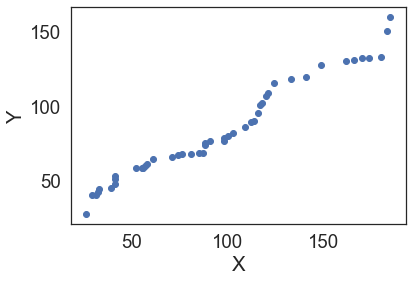

In [15]:
x = y_test.values.reshape(1,-1)[0]
y = lgb_y_test_pred

plt.figure()
plt.scatter(np.sort(x), np.sort(y))
plt.xlabel('X')
plt.ylabel('Y')
plt.show()
plt.close()

In [16]:
x

array([100, 112, 162,  61, 121,  56,  76, 174,  41, 120,  57,  33,  32,
        29, 180, 124,  71,  74,  39,  31, 170,  98,  91, 183, 116,  55,
        88, 118, 166,  52,  41,  85,  58, 185, 103, 114,  88,  26,  87,
        81, 133, 117, 141,  98, 109,  41, 149], dtype=int64)

In [17]:
y

array([132.142549  ,  64.40912406,  68.17054506,  67.46029256,
       150.21602978,  76.85997359,  78.91877657, 131.05583588,
        61.29839717, 127.75924505,  27.47818261,  86.15680378,
        44.5518612 ,  75.5625735 , 132.142549  ,  59.70960596,
       119.81103605,  68.69636486, 133.27262731,  68.37433456,
       101.09262348, 108.91269395,  67.90760502, 160.09355972,
        53.3090796 ,  58.33540745,  66.32067546,  51.08913407,
        45.28412294,  74.0951809 , 118.31529866, 102.12374273,
        40.53315228,  80.14142703,  42.66483917,  40.37589118,
        89.76440969,  47.71519967,  90.29543802, 130.4325893 ,
       107.22894701, 115.89006053,  95.6410058 ,  76.55007779,
        82.28780094,  58.33540745,  58.28417901])

### Econometrics

In [18]:
target = 'CloseOut_new'
formula = target + " ~ "
for col in df_train.columns:
    if col!=target:
        formula+=col
        formula+=" + "

expr = formula[:-3]
print(expr)

CloseOut_new ~ PlannedEnrollment + ActualEnrollment + ActualRandomizedDosed + ActualEarlyTerminated + PercEnrollmentCompleted + PlannedSites + ActiveSites + LSO_ActualDate + DBL_ActualDate + numValsLSO + numValsDBL + PrimaryStudy_to_Synopsis + Synopsis_to_Protocol + FSS_to_FSI + LSI_to_LSO + AE + CM + DS + DV + EG + EX + FA + LB + MH + PR + SS + VS + Lock_duration + Expected_CloseOut + Ontime + Unlocks + COVID + 0 + I + II + III + IV + GI + NS + NonCore + Oncology + RGH + PercActualCompetedTrial + Celerion + IQVIA + Other + PPD + PRA


In [19]:
expr = """CloseOut_new ~ PlannedEnrollment + ActualEnrollment + ActualRandomizedDosed + ActualEarlyTerminated + PercEnrollmentCompleted + PlannedSites + ActiveSites + LSO_ActualDate + DBL_ActualDate + numValsLSO + numValsDBL + PrimaryStudy_to_Synopsis + Synopsis_to_Protocol + FSS_to_FSI + LSI_to_LSO + AE + CM + DS + DV + EG + EX + FA + LB + MH + PR + SS + VS + 0 + I + II + III + IV + GI + NS + NonCore + Oncology + RGH + PercActualCompetedTrial + Celerion + IQVIA + Other + PPD + PRA"""


In [20]:
expr = """CloseOut_new ~ Lock_duration"""

In [21]:
x_train = x_train.fillna(x_train.median())

In [22]:
x_train[['Lock_duration']]

,Lock_duration
1,0.0
5,0.0
6,0.0
7,0.0
9,0.0
...,...
308,0.0
309,0.0
310,0.0
311,0.0


In [23]:

# y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
# y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

poisson_training_results = sm.GLM(y_train, x_train, family=sm.families.Poisson()).fit()

print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           CloseOut_new   No. Observations:                  207
Model:                            GLM   Df Residuals:                      169
Model Family:                 Poisson   Df Model:                           37
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2041.6
Date:                Mon, 16 Aug 2021   Deviance:                       2847.4
Time:                        11:43:59   Pearson chi2:                 2.95e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
PlannedEnrollment       

In [24]:
import statsmodels
import statsmodels.api as sm
import matplotlib.pyplot as plt

statsmodels.__version__

'0.12.2'

In [31]:
y, X = y_train, x_train

X['intercept'] = 1

model = sm.OLS(y, X)
results_fu = model.fit()

print(results_fu.summary())

                            OLS Regression Results                            
Dep. Variable:           CloseOut_new   R-squared:                       0.335
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     2.299
Date:                Mon, 16 Aug 2021   Prob (F-statistic):           0.000183
Time:                        11:48:29   Log-Likelihood:                -1018.0
No. Observations:                 207   AIC:                             2112.
Df Residuals:                     169   BIC:                             2239.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
PlannedEnrollment       

In [32]:
results_fr = model.fit_regularized(L1_wt=1, alpha=9.8610889066061, start_params=results_fu.params)
final = sm.regression.linear_model.OLSResults(model, 
                                              results_fr.params, 
                                              model.normalized_cov_params)

print(final.summary())

                            OLS Regression Results                            
Dep. Variable:           CloseOut_new   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.9297
Date:                Mon, 16 Aug 2021   Prob (F-statistic):              0.589
Time:                        11:48:39   Log-Likelihood:                -1041.0
No. Observations:                 207   AIC:                             2158.
Df Residuals:                     169   BIC:                             2285.
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
PlannedEnrollment       

In [30]:
final.params

PlannedEnrollment           0.044198
ActualEnrollment           -0.007598
ActualRandomizedDosed      -0.010588
ActualEarlyTerminated       0.012792
PercEnrollmentCompleted     0.000000
PlannedSites                0.009548
ActiveSites                -0.032965
numValsLSO                  0.000000
numValsDBL                  0.000000
PrimaryStudy_to_Synopsis   -0.050954
Synopsis_to_Protocol       -0.005715
FSS_to_FSI                  0.000000
LSI_to_LSO                 -0.002760
AE                          0.000000
CM                          0.000000
DS                          0.000000
DV                          0.000000
EG                          0.000000
EX                          0.000000
FA                          0.000000
LB                          0.000000
MH                          0.000000
PR                          0.000000
SS                          0.000000
VS                          0.000000
Lock_duration               1.577688
Expected_CloseOut           0.286300
O

### Lock Duration Analysis

In [133]:
df_lock_duration_analysis = df[df['DBL_ActualDate'].astype(str).str.contains('2019|2020|2021')]

df_lock_duration_analysis = df_lock_duration_analysis[df_lock_duration_analysis.TA!='NonCore']

df_lock_duration_analysis

AttributeError: 'DataFrame' object has no attribute 'TA'

In [96]:
df_lock_duration_analysis = df_lock_duration_analysis[['ProtocolNum','TA','ProtocolPhase','Lock_duration','CloseOut_new']]

df_lock_duration_analysis = df_lock_duration_analysis[df_lock_duration_analysis.ProtocolPhase!='0']

In [97]:
df_lock_duration_analysis

,ProtocolNum,TA,ProtocolPhase,Lock_duration,CloseOut_new
1,C16014 Korea Continuation,Oncology,III,0.0,51
2,C34007,Oncology,I,8.0,100
4,TAK-438_302,GI,III,0.0,112
5,TAK-438_304,GI,III,0.0,146
8,TAK-418-0004,NS,I,19.0,229
...,...,...,...,...,...
269,SHPELA-701,RGH,IV,0.0,109
270,SPD489-348,NS,III,0.0,27
271,TAK-620-1019,RGH,I,0.0,99
272,TAK-620-1020,RGH,I,0.0,399


In [98]:
df_probs_success = pd.read_csv('./Data/Operational_Data/Probability_Success.csv')

df_probs_success

,TA,ProtocolPhase,Probability_Success
0,Oncology,I,0.066865
1,Oncology,II,0.116085
2,Oncology,III,0.355000
3,Oncology,IV,1.000000
4,GI,I,0.234736
5,GI,II,0.308052
6,GI,III,0.516000
7,GI,IV,1.000000
8,NS,I,0.194133
9,NS,II,0.265209


In [99]:
df_lock_duration_analysis = pd.merge(df_lock_duration_analysis, 
                                     df_probs_success,  how='left', 
                                     left_on=['TA','ProtocolPhase'], right_on = ['TA','ProtocolPhase'])

In [100]:
df_lock_duration_analysis['Saved_days_low'] = df_lock_duration_analysis['Lock_duration']*0.376
df_lock_duration_analysis['Saved_days_normal'] = df_lock_duration_analysis['Lock_duration']*1.5777
df_lock_duration_analysis['Saved_days_high'] = df_lock_duration_analysis['Lock_duration']*2.779

df_lock_duration_analysis['Added_NPV_low'] = df_lock_duration_analysis['Saved_days_low']*df_lock_duration_analysis['Probability_Success']*1.0
df_lock_duration_analysis['Added_NPV_normal'] = df_lock_duration_analysis['Saved_days_normal']*df_lock_duration_analysis['Probability_Success']*1.0
df_lock_duration_analysis['Added_NPV_high'] = df_lock_duration_analysis['Saved_days_high']*df_lock_duration_analysis['Probability_Success']*1.0



df_lock_duration_analysis

,ProtocolNum,TA,ProtocolPhase,Lock_duration,CloseOut_new,Probability_Success,Saved_days_low,Saved_days_normal,Saved_days_high,Added_NPV_low,Added_NPV_normal,Added_NPV_high
0,C16014 Korea Continuation,Oncology,III,0.0,51,0.355000,0.000,0.0000,0.000,0.000000,0.000000,0.000000
1,C34007,Oncology,I,8.0,100,0.066865,3.008,12.6216,22.232,0.201130,0.843943,1.486542
2,TAK-438_302,GI,III,0.0,112,0.516000,0.000,0.0000,0.000,0.000000,0.000000,0.000000
3,TAK-438_304,GI,III,0.0,146,0.516000,0.000,0.0000,0.000,0.000000,0.000000,0.000000
4,TAK-418-0004,NS,I,19.0,229,0.194133,7.144,29.9763,52.801,1.386886,5.819389,10.250416
...,...,...,...,...,...,...,...,...,...,...,...,...
112,SHPELA-701,RGH,IV,0.0,109,1.000000,0.000,0.0000,0.000,0.000000,0.000000,0.000000
113,SPD489-348,NS,III,0.0,27,0.511000,0.000,0.0000,0.000,0.000000,0.000000,0.000000
114,TAK-620-1019,RGH,I,0.0,99,0.313233,0.000,0.0000,0.000,0.000000,0.000000,0.000000
115,TAK-620-1020,RGH,I,0.0,399,0.313233,0.000,0.0000,0.000,0.000000,0.000000,0.000000


In [101]:
df_lock_duration_analysis.sum().iloc[-3:]/3

Added_NPV_low         9.28422
Added_NPV_normal    38.956685
Added_NPV_high      68.619274
dtype: object

In [105]:
a = df_lock_duration_analysis.Saved_days_normal.mean()

In [106]:
b = df_lock_duration_analysis.CloseOut_new.mean()

In [107]:
a/b

0.055412022841051324

In [152]:
a

6.0545923076923085

In [153]:
b

109.26495726495726

In [43]:
 df_lock_duration_analysis.Saved_days_normal.mean()

NameError: name 'df_lock_duration_analysis' is not defined